# Generating relative value trade ideas using PCA

The goal of this exercise is to implement a framework for identifying and analyzing relative value trades using PCA and Python. 

## Setting it up

Let's first import the dependencies we will need. 

In [1]:
%matplotlib inline

import quandl

import numpy as np
from numpy import array
import pandas as pd
from operator import sub
import pickle
import math
import itertools as iter
import datetime as dt
import os
from scipy.misc import comb
import seaborn as sns
import firvtools as firv
import string


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm, rc
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, KernelPCA

from IPython.display import display, HTML


rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

print ("Loaded!")

cwd = os.getcwd()
dataDir = cwd+"/depo/Data/"
saveDir = cwd+"/depo/Outputs/"

Loaded!


We will be performing the analysis on swap curves in JPY, EUR, GBP, USD.

In [168]:
brawData = pd.read_csv("bookData.csv", sep=",")

brawData["Date"] = pd.to_datetime(brawData["Date"], infer_datetime_format=True)
brawData.set_index("Date", drop=True, inplace=True)

bstart = dt.datetime(2010, 1, 4)
bend = dt.datetime(2011, 10, 3)

brawData = brawData.astype(float) 
brawData *= 100
brawData = brawData - brawData.mean()
brawData.rename(columns=lambda x: x[:-1]+"y", inplace=True)


currencies = ["EUR", "GBP", "JPY", "USD"]
fwds = {}
par = {}

def loadCurrencies(ccylist):
    for ccy in currencies:
        fwds[ccy] = pd.read_pickle(dataDir+"fwd"+ccy)[::-1]
        temp = pd.read_pickle(dataDir+ccy)[::-1]
        if temp.columns.values[0][-1] != "y":
            temp.rename(columns=lambda x: str(x[3:])+"y", inplace=True)
        par[ccy] = temp
        print ("Loaded "+ccy)
    return

def matchTenors(c1, c2):
    assets = list(set(c1.columns.values) & set(c2.columns.values))
    assets.sort(key=lambda x: len(x.split("y")))
    assets.sort(key=lambda x: int(x.split("y")[0]))
    r1 = c1.copy()["assets"]
    r2 = c2.copy()["assets"]
    return r1, r2
    
loadCurrencies(currencies)

Loaded EUR
Loaded GBP
Loaded JPY
Loaded USD


,2y,5y,7y,10y
Date,,,,
2010-01-04,51.885937,82.215625,91.7,86.257031
2010-01-11,39.685937,75.715625,85.8,81.857031
2010-01-18,31.285937,75.515625,75.8,71.957031
2010-01-25,28.185937,69.115625,70.7,68.857031
2010-02-01,29.385937,67.015625,67.6,65.757031


,2y,5y,7y,10y
Date,,,,
2012-05-14,-59.614063,-109.884375,-113.7,-107.142969
2012-05-21,-59.614063,-111.384375,-114.9,-109.742969
2012-05-28,-59.614063,-117.584375,-120.1,-116.442969
2012-06-04,-59.614063,-124.684375,-131.8,-132.042969
2012-06-11,-59.614063,-116.684375,-122.6,-122.342969


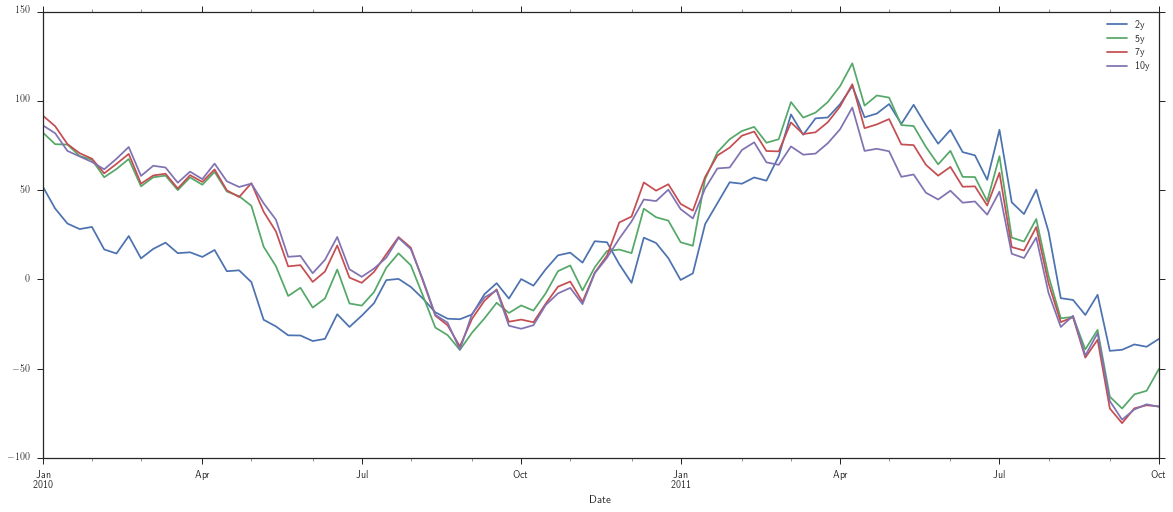

In [169]:

start = dt.datetime(2015, 4, 1)
end = dt.datetime(2016, 4, 1)

currency = "GBP"
#rawData = fwds[currency]
assets = brawData.columns.values
data = brawData[bstart:bend]
display(data.head())
sns.set_style("ticks")
rawplot = data.plot(figsize=(20,8))
display(brawData.dropna().tail())

firstDate = data.index[0].strftime("%d %b %y")
lastDate = data.index[-1].strftime("%d %b %y")

## Writing the static PCA function

We'll try to write a function staticPCA. It takes in our raw data, number of components we are interested in (default 4) and resample frequency on the raw data (default 1). It also takes in corrW (default 20), which is used to determine how many periods to use in the rolling correlation of reconstructed factors.

The output of the function will be a dictionary of resultant eigenvalues, eigenvectors, the covariance matrix, and historical reconstructed factors.

Further down the line, we will also need k-factor residuals (residuals found by reconstructing the data using only k-1 factors). We write this helper function and use it in the staticPCA function now, to make things a bit easier.

(Edit: The re-orientation function was written after the fact. Considerable time was spent on automating a way to re-orient the PCs post ante. However, given that yield curve dynamics are understood in that PC1 is level, PC2 slope and PC3 curvature, we can write a reorient function. The reorient function calculates correlations between the level, slope, fly and the individual PCs and re-orients the PCs as they should be. )

In [170]:
def kfacReconstruct(data, evTable, k=3, cols = [], auto= 0):
    ## Auto reorients EVs and PCs
    ## Pick securities to receive data for. If no input, do all. 
    if cols ==[]: 
        cols = data.columns.values
    
    # Returns k-factor reconstruction when given the data and Eigenvectors
    
    result = {}
    
    totFactors = len(evTable.columns.values)
    if totFactors < k:
        print ("Error! Total factors are less than k.")
        return
    
    # get demeaned data
    meanVals = data.mean()
    demeaned = data - meanVals
    
    #reconstruct historical factor time series
    factorTS = demeaned.dot(evTable)
    if auto != 0:
        reOrient = pcReorient(data, factorTS, tol=auto)[:totFactors]
        newEVs = evTable.copy()
        newFactors = factorTS.copy()
        for i in range(totFactors):
            newEVs.loc[:, evTable.columns[i]] *= reOrient[i]
            newFactors.loc[:, factorTS.columns[i]] *= reOrient[i]
        factorTS = newFactors
        evTable = newEVs

    #inverse of eigenvectors
    invEV = pd.DataFrame(np.linalg.pinv(evTable.values), evTable.columns, evTable.index)

    #drop columns to adjust for k factors
    factorTS.drop(factorTS.columns[range(len(factorTS.columns.values))[k:]], axis=1, inplace=True)
    
    #drop rows to adjust for k factors
    invEV.drop(invEV.index[range(len(invEV.index.values))[k:]], axis=0, inplace=True)
    
    #### Reconstruction using k factors
    kRebuild = factorTS.dot(invEV)
    kResiduals = demeaned - kRebuild
    reRaw = kRebuild + meanVals
    
    result["factorTS"] = factorTS
    result["rebuildRaw"] = reRaw[cols]
    result["residuals"] = kResiduals[cols]
    
    return result, evTable
    
def pcReorient(data, factors, tol=2):
    lenData = len(data.columns.values)
    numCurves = lenData//2
    numFlies = comb(lenData, 3)    
    
    pc1corr, pc2corr, pc3corr = 1, 1, 1
        
    if tol > numCurves or tol > numFlies:
        print ("Error.")
        return
    numFactors = len(factors.columns.values)
    if numFactors >=1:
        ## check pc1
        split = lenData//tol
        pc1check = pd.concat([data.ix[:,j*split] for j in range(tol)], axis=1)
        pc1corr = pc1check.corrwith(factors["PC1"]).mean()
    if numFactors >=2:
        ## check pc2
        pc2check = pd.concat([data.ix[:,-i]-data.ix[:,i] for i in range(numCurves)], axis=1)
        pc2corr = pc2check.corrwith(factors["PC2"]).mean()
    if numFactors >=3:
        ## check pc3
        pc3check = data.ix[:,numCurves]*2 - data.ix[:,0] - data.ix[:,-1]
        pc3corr = factors["PC3"].corr(pc3check).mean()
    
    
    return np.sign([pc1corr, pc2corr, pc3corr])

def staticPCA(data, n=3, freq=1, corrW = 12, autoOrient=2, plot=True):
    '''
    This function returns a dictionary with the following key value combinations:
    key    | Value
    raw    | DF with raw data (as resampled)
    covM   | Covariance matrix of raw data
    evals  | n eigenvalues
    evecs  | n eigenvectors
    facTS  | time series of reconstructed factors using raw data. 
    reRaw  | Rebuilt raw data from n EVs, and accompanying residuals
    resid  | Residuals (Actual - Reconstructed)
    facCR  | Rolling cross correlations between factors
    '''
    results = {}
    
    ## resample data based on freq and calc demeaned data
    raw = data.iloc[::freq, :]
    results["rawDat"] = raw
    meanVals = raw.mean()
    demeaned = raw - meanVals
    
    ## Covariance Matrix
    covM = raw.cov()
    results["covM"] = covM
    
    ## PCA
    evals, evecs = np.linalg.eig(covM)
    epairs = [(np.abs(evals[i]), evecs[:,i]) for i in range(len(evals))]
    epairs.sort(key=lambda x: x[0], reverse=True)
    evals = sorted([i*100/sum(evals) for i in evals])[::-1][:n]
    results["evals"] = evals

    evTable = pd.DataFrame(index=covM.index)
    for i in range(n):
        evTable.insert(i, "PC"+str(i+1), epairs[i][1])

    ## Reconstruct
    reConResult = kfacReconstruct(raw, evTable, n, auto=autoOrient)
    reconstructed = reConResult[0]
    evTable = reConResult[1].copy()
    evTable.index = covM.index
    results["evecs"] = evTable
    resid = reconstructed["residuals"]
    facTS = reconstructed["factorTS"]
    reRaw = reconstructed["rebuildRaw"]
    
    results["resid"] = resid
    results["facTS"] = facTS
    results["reRaw"] = reRaw
    

    ## Rolling correlations of factors
    facCR = pd.DataFrame()
    combos =[facTS[list(pair)] for pair in list(iter.combinations(facTS.columns, 2))]
    for df in combos:
        cols = df.columns.values
        facCR["".join(cols)] = facTS[cols[0]].rolling(window=corrW).corr(other=facTS[cols[1]])

    results["facCR"] = facCR
    
    return results




## Playing around with the function results

Let's load our German Yield curve data into this function and see what we get.

In [171]:
print("Eigenvectors:")
pca1 = staticPCA(data, freq=1, n=1)
pca2 = staticPCA(data, freq=1, n=2)
pca3 = staticPCA(data, freq=1, n=3)
display(pca3["evecs"])
print("Eigenvalues:")
display(pca3["evals"])

Eigenvectors:


,PC1,PC2,PC3
2y,0.421718,-0.835988,0.308821
5y,0.554351,-0.044949,-0.825156
7y,0.530166,0.287945,0.421667
10y,0.483500,0.464964,0.214347


Eigenvalues:


[92.510426610001929, 7.1917777461596337, 0.25374786518728254]

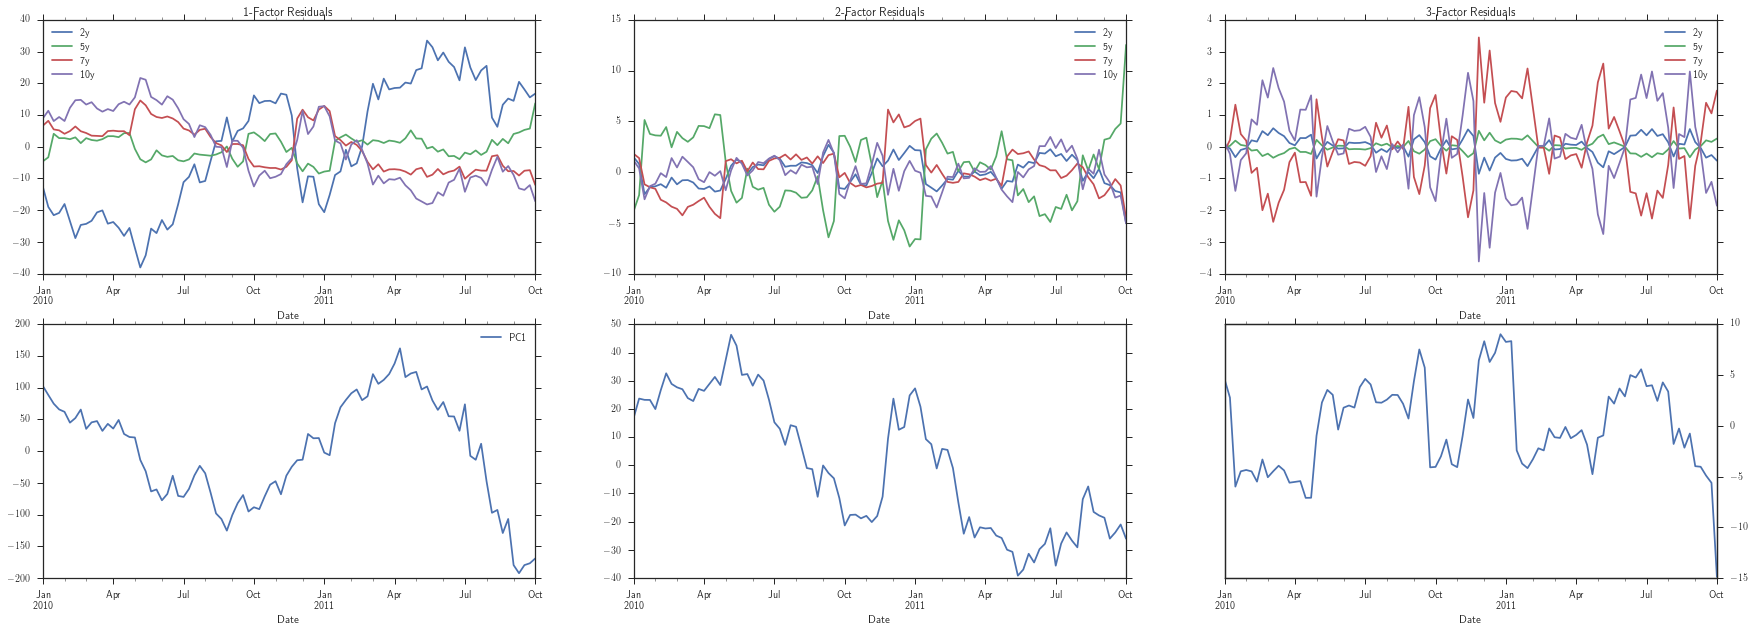

In [172]:
# Plot it.

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(30, 10)
    
pca1["resid"].plot(ax=axes[0, 0], title="1-Factor Residuals")
pca1["facTS"].plot(ax=axes[1, 0])

pca2["resid"].plot(ax=axes[0, 1], title="2-Factor Residuals")
pca2["facTS"]["PC2"].plot(ax=axes[1, 1])

pca3["resid"].plot(ax=axes[0, 2], title="3-Factor Residuals")
pca3["facTS"]["PC3"].plot(ax=axes[1, 2], secondary_y="PC3")


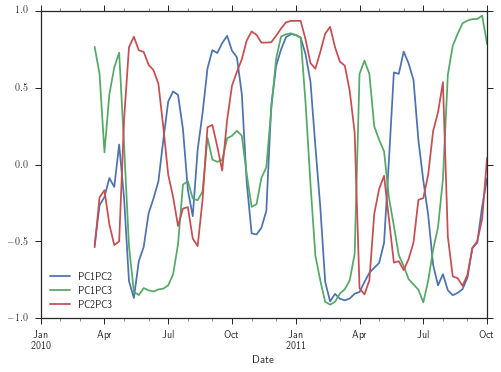

In [173]:
pca3["facCR"].plot()

# Residuals

We create a one page summary of the residuals, which might potentially highlight attractive trades.


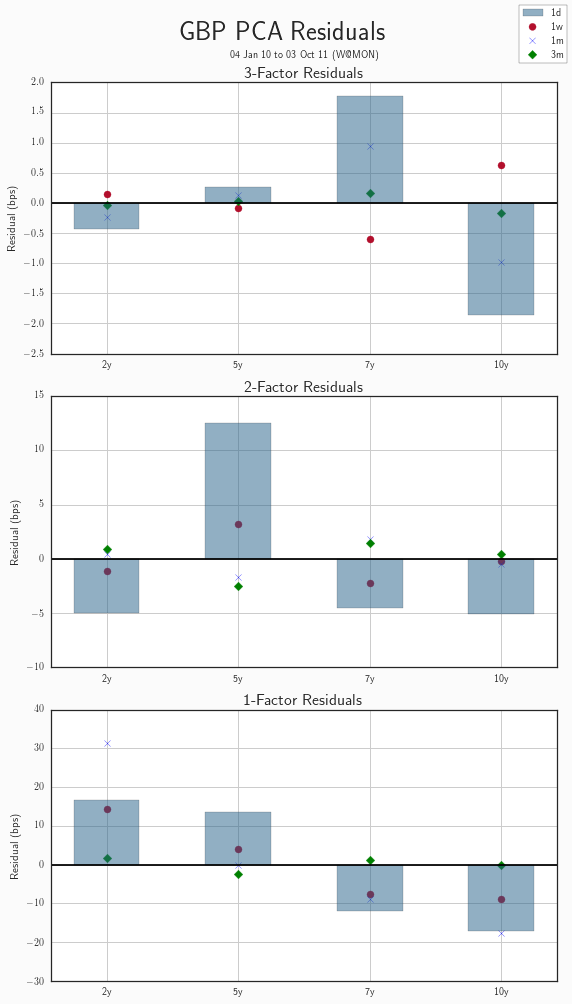

In [174]:
########### Residuals ############
## LEVEL
xvals = range(len(assets))

relVal1 = pd.DataFrame()
relVal1 = pca1["resid"].ix[[-1, -5, -20, -60]]
relVal1.index = ["1d", "1w", "1m", "3m"]
relVal1 = relVal1.transpose()

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(8, 14), dpi=400, facecolor="#fbfbfb")
fig.suptitle("%s PCA Residuals"%currency, fontsize=26)

### 1-Factor PCA residual 
ax1 = plt.subplot2grid((3, 1), (2, 0), colspan=1)
xvals = range(len(assets))
lday=ax1.bar(xvals, relVal1["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax1.set_xticks(xvals)
ax1.set_xticklabels(assets)
plt.grid()
s = 25
lwk= ax1.scatter(xvals, relVal1["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
lmnth=ax1.scatter(xvals, relVal1["1m"], color='b', marker = "x", s=1.5*s, label="1m")
lquart=ax1.scatter(xvals, relVal1["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax1.axhline(0, color="black")
ax1.set_title("1-Factor Residuals", fontsize="16")
#ax1.set_axis_bgcolor('#f8fcff')
ax1.set_ylabel("Residual (bps)")

## 2-Factor PCA residual

relVal2 = pd.DataFrame()
relVal2 = pca2["resid"].ix[[-1, -5, -20, -60]]
relVal2.index = ["1d", "1w", "1m", "3m"]
relVal2 = relVal2.transpose()

ax2 = plt.subplot2grid((3, 1), (1, 0), colspan=1)
ax2.bar(xvals, relVal2["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax2.set_xticks(xvals)
ax2.set_xticklabels(assets)
plt.grid()
s = 25
ax2.scatter(xvals, relVal2["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
ax2.scatter(xvals, relVal2["1m"], color='b', marker = "x", s=1.5*s, label="1m")
ax2.scatter(xvals, relVal2["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax2.axhline(0, color="black")
ax2.set_title("2-Factor Residuals", fontsize="16")
#ax2.set_axis_bgcolor('#f8fcff')
ax2.set_ylabel("Residual (bps)")

## 3-Factor PCA residual


relVal3 = pd.DataFrame()
relVal3 = pca3["resid"].ix[[-1, -5, -20, -60]]
relVal3.index = ["1d", "1w", "1m", "3m"]
relVal3 = relVal3.transpose()

ax3 = plt.subplot2grid((3, 1), (0, 0), colspan=1)
ax3.bar(xvals, relVal3["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax3.set_xticks(xvals)
ax3.set_xticklabels(assets)
plt.grid()
s = 25
ax3.scatter(xvals, relVal3["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
ax3.scatter(xvals, relVal3["1m"], color='b', marker = "x", s=1.5*s, label="1m")
ax3.scatter(xvals, relVal3["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax3.axhline(0, color="black")
ax3.set_title("3-Factor Residuals", fontsize="16")
#ax3.set_axis_bgcolor('#f8fcff')
ax3.set_ylabel("Residual (bps)")

freq = firv.freqRules[pd.infer_freq(data.index)]
plt.text(0.5, 1.1,'%s to %s (%s)'%(firstDate, lastDate, freq), ha='center', va='center', transform=ax3.transAxes, fontsize=10)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.figlegend([lday, lwk, lmnth, lquart], ["1d", "1w", "1m", "3m"], frameon=True,loc="upper right" )

plt.savefig("%s/depo/%s-PCA Residuals - %s %s"%(cwd, "Bund", lastDate, freq))


At the end of the exercise, we will dive quite a bit deeper into the results. For now, let's go back implement a rolling PCA using our staticPCA function.

# Rolling PCA

Here we try to implement a rolling PCA in order to study the stability of eigenvectors and eigenvalues over time.


In [175]:
def rollingPCA(data, lb=30, n=3, corrW=12, skip=1, autoOrient=2):
    """
    For now, this function returns a data frame with time series of eigenvalues and eigenvectors of a rolling PCA. 
    """

    rollResult = {}
    
    assets = data.columns.values
    pcCols = ["PC"+str(i+1) for i in range(n)]
    eVecCols = [pc+asset for pc in pcCols for asset in assets]
    
    # Create dataframe for results. 
    accumEvals = pd.DataFrame(columns = range(1, n+1), index=data.index.values[lb:])
    accumEvecs = dict.fromkeys(pcCols, pd.DataFrame(columns=assets, index=data.index.values[lb:]))
    alleVectors = pd.DataFrame(index=data.index.values[lb:], columns = eVecCols)
    
    ### Rolling PCA - Loop and save data.
    
    for i in range(0, len(data.index)-lb, skip):
        
        temp = data[i:lb+i]
        currDate = data.index.values[lb+i]
        res = staticPCA(temp, n=n, corrW=corrW, autoOrient = autoOrient)

        ## Save eigenvalues
        eigenvalues = res["evals"]
        for j in range(len(eigenvalues)):
            accumEvals.set_value(currDate,j+1,eigenvalues[j])

        ## Save eigenvectors
        eigenvectors = res["evecs"]
        tempDict = {}
        for pc in pcCols:
            factor = eigenvectors[pc]
            #print (i, pc, factor.tolist())
            for k in range(len(assets)):
                alleVectors.set_value(currDate, pc+assets[k], factor[k])
    
    #### Split data into PC1, PC2, PC3 and drop NAs.
    
    accumEvals = accumEvals.dropna()

    grouped = alleVectors.groupby(lambda x: x[:3], axis=1)
    
    for pc in pcCols:
        accumEvecs[pc] = grouped.get_group(pc).dropna()
        accumEvecs[pc].rename(columns=lambda x: x[3:], inplace=True)
    accumEvals.columns = pcCols
    rollResult["evectors"] = accumEvecs
    rollResult["evalues"] = accumEvals
    
    ## Secret
    rollResult["master"] = alleVectors.dropna()
    
    return rollResult
            
#pcaResults = rollingPCA(rawData[:data.index.values[0]].dropna(), lb=252, skip=30, autoOrient=3)
pcaResults = rollingPCA(data, lb=30, autoOrient=2)
print ("Done!")


Done!


Let's see what the eigenvalues and eigenvectors look like over time. Their stability would highlight the effectiveness of the PCA based model for this particular set of data.

Eigenvalues:


,PC1,PC2,PC3
2011-09-05,97.8908,1.99433,0.0938771
2011-09-12,98.6993,1.19914,0.0851609
2011-09-19,99.2214,0.685638,0.0796252
2011-09-26,99.4946,0.41485,0.0792561
2011-10-03,99.5891,0.323753,0.0769784


####### PC1 historical ########
                  2y        5y        7y       10y
2011-09-05  0.438736  0.560715   0.52585  0.465393
2011-09-12  0.444037  0.555402  0.526372  0.466147
2011-09-19  0.444543  0.551767  0.527362  0.468854
2011-09-26  0.446305  0.548858    0.5271  0.470885
2011-10-03  0.448604  0.546656  0.526953  0.471426
####### PC2 historical ########
                  2y        5y        7y       10y
2011-09-05 -0.867975  0.102595  0.241767  0.421476
2011-09-12 -0.865008    0.1109  0.230338  0.431748
2011-09-19 -0.866512  0.122385  0.218507   0.43178
2011-09-26  -0.86523  0.131111  0.204097  0.438783
2011-10-03 -0.868636  0.148763  0.203629  0.426469
####### PC3 historical ########
                  2y        5y         7y       10y
2011-09-05 -0.230272  0.734706 -0.0270569 -0.637534
2011-09-12 -0.225091  0.758916 -0.0737028 -0.606588
2011-09-19 -0.213259  0.765317 -0.0865553 -0.601098
2011-09-26 -0.210025  0.762068 -0.0723578   -0.6082
2011-10-03 -0.189744  0.761685 -

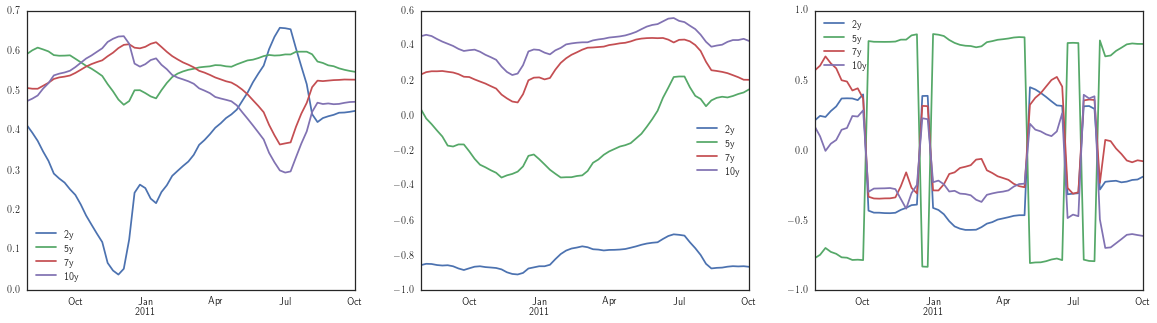

In [176]:

print ("Eigenvalues:")
display(pcaResults["evalues"].tail())
print ("####### PC1 historical ########")
print (pcaResults["evectors"]["PC1"].tail())
print ("####### PC2 historical ########")
print (pcaResults["evectors"]["PC2"].tail())
print ("####### PC3 historical ########")
print (pcaResults["evectors"]["PC3"].tail())

pc1raw = pcaResults["evectors"]["PC1"]
pc2raw = pcaResults["evectors"]["PC2"]
pc3raw = pcaResults["evectors"]["PC3"]

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20, 5)

pc1raw.plot(ax=axes[0])
pc2raw.plot(ax=axes[1])
pc3raw.plot(ax=axes[2])


Wait, what? 

Ok, so this is because the static PCAs that are being run sometimes will generate eigenvectors that are in the opposite orientation of the previous eigenvector. But this isn't really a point to worry about. Eigenvectors would be equivalent to their negatives. What we can do, however, is to try our best to flip the eigenvectors to the direction that makes sense. 

The following function tries to achieve this task. It is not perfect, but it does not affect the purposes of the exercise (which is to determine the stability of the EVs). The stability is discernible well enough with the smoothing applied.

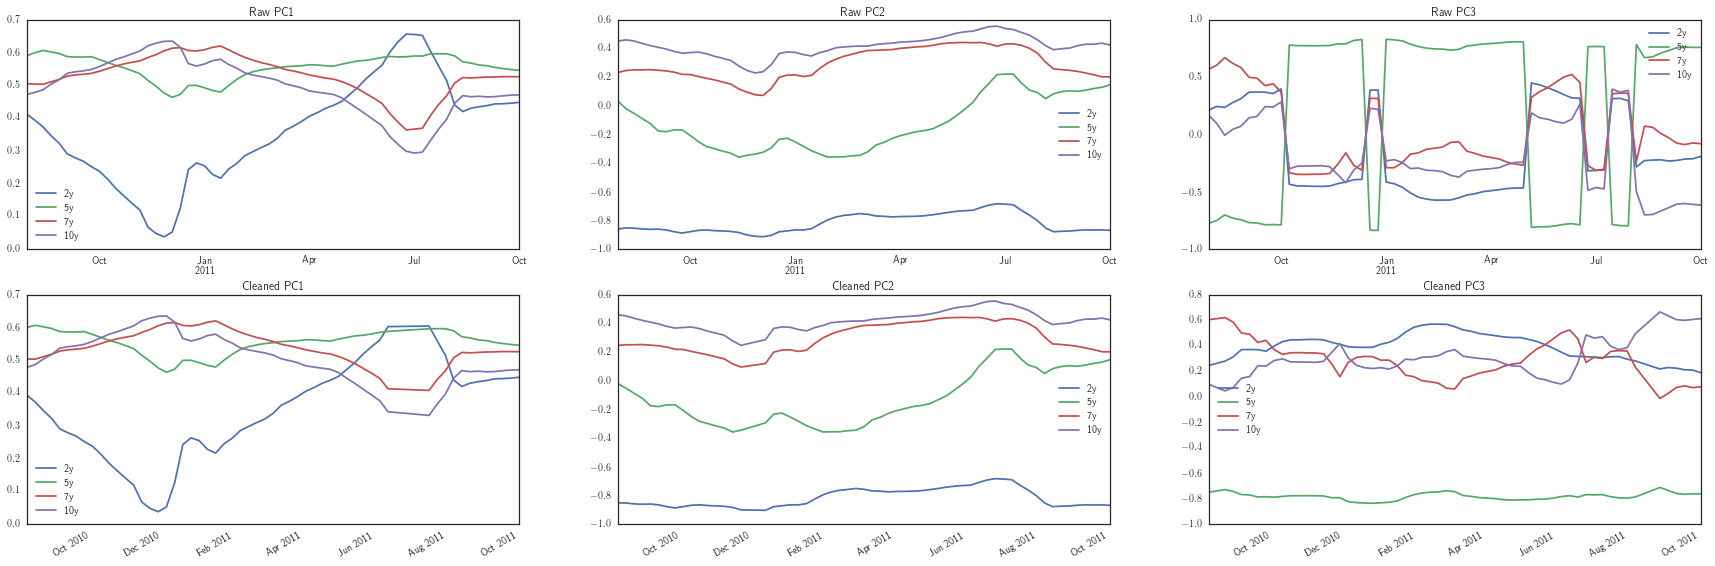

In [177]:

def cleanPCs(input, smoothing=1):
    newdf = pd.DataFrame(index=input.index.values, columns=input.columns.values)
    flag = "flipped"

    for i in range(1, len(input)):
        if i ==1:
            prevfactor = input.iloc[i-1]
        else:
            prevfactor = newdf.iloc[i-1]
        factor = input.iloc[i]
        negfactor = [-i for i in factor.tolist()]

        orig = sum([np.abs(x) for x in (factor-prevfactor).tolist()])
        new = sum([np.abs(x) for x in (-factor-prevfactor).tolist()])
        
        if orig > new:
            for s in range(len(input.columns.values)):
                newdf.set_value(newdf.index.values[i], newdf.columns.values[s], -1*input.iloc[i, s])
                flag = "flipped"
        else:
            for s in range(len(input.columns.values)):
                newdf.set_value(newdf.index.values[i], newdf.columns.values[s], input.iloc[i, s])
                flag = "same"
    
    if smoothing==1:
        newdf = newdf[newdf.apply(lambda x: np.abs(x - x.mean()) / x.std() < 2.5).all(axis=1)]
        newdf = newdf[newdf.apply(lambda x: np.abs(x - x.mean()) / x.std() < 2.5).all(axis=1)]

        
    return newdf
            

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(30, 10)
    
pc1raw.plot(ax=axes[0, 0], title="Raw PC1")
cleanPCs(pc1raw).plot(ax=axes[1, 0], title="Cleaned PC1")

pc2raw.plot(ax=axes[0, 1], title="Raw PC2")
cleanPCs(pc2raw).plot(ax=axes[1, 1], title="Cleaned PC2")

pc3raw.plot(ax=axes[0, 2], title="Raw PC3")
cleanPCs(pc3raw).plot(ax=axes[1, 2], title="Cleaned PC3")

Ah, much better. There are still issues with certain individual eigenvectors but we can zoom in on these individual ones and spotcheck them if needed. As we can see, the PCs are generally quite stable.

What about the Eigenvalues?

               PC12y     PC15y     PC17y    PC110y     PC22y      PC25y  \
2010-08-02   0.41257  0.591336  0.506175  0.473176 -0.859155  0.0361406   
2010-08-09  0.393904  0.600663  0.504253  0.479346 -0.851489 -0.0181097   
2010-08-16  0.373413  0.607386  0.504189  0.487277 -0.852555 -0.0504226   
2010-08-23  0.346878  0.602902  0.511588  0.504444 -0.858494 -0.0867135   
2010-08-30   0.32331  0.597929  0.519103  0.518154 -0.861357  -0.121306   

               PC27y    PC210y     PC32y     PC35y     PC37y     PC310y  
2010-08-02  0.233974  0.453655  0.213033 -0.774062  0.571302   0.170468  
2010-08-09  0.247719  0.461816  0.246263 -0.749741  0.606079  0.0995533  
2010-08-16   0.25274  0.454675  0.238237 -0.700793  0.672391  -0.004763  
2010-08-23  0.252615  0.437784  0.280675 -0.728933  0.622651  0.0467329  
2010-08-30  0.254218  0.422756  0.313806 -0.742754  0.586912  0.0733168  


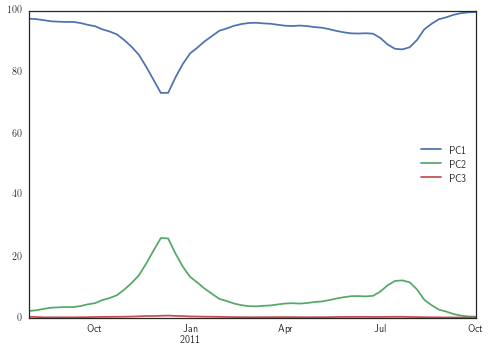

In [178]:
pcaResults["evalues"].plot()
print (pcaResults["master"].head())

Not too bad. 

# Snapshots over time

Alternatively, we can look at a snapshot of the eigenvectors and values at different points in time. This will hopefully provide a bit more insight than the previous rolling PCA charts which were quite noisy. This function will generate a subset of the rolling PCA results, showing only snapshots on an input set of dates and a lookback period on the rolling PCA.

In [126]:
lb = 40
lastDate = data.index.values[0]
lastIndex = list(brawData.index.values).index(lastDate)
testDates = [data.index.values[i] for i in range(lb, len(data.index.values), 10)]

target = pd.DataFrame(index=testDates)
print (testDates)

orig = pcaResults["master"]

result = target.join(orig)
#print (result)

def pcaSnapshot(dates, data, lb=30, n=3,orient=True, tol=1.5):
    # Returns tuple of evalues and a dict of evectors.
    reorient = len(dates)*[1]
    
    pcaResults = rollingPCA(data, lb=lb, n=n)
    orig = pcaResults["master"]
    evectors = pd.DataFrame(index=dates).join(orig)
    
    evalues = pd.DataFrame(index=dates).join(pcaResults["evalues"])

    pcCols = evalues.columns.values
    
    grouped = evectors.groupby(lambda x: x[:3], axis=1)
    
    accumEvecs = dict.fromkeys(pcCols, pd.DataFrame(columns=data.columns.values, index=data.index.values[lb:]))
    flag = 0
    for pc in pcCols:
        if flag == 0 and orient :
            flag = 1
            temp = grouped.get_group(pc).dropna()
            temp['orient'] = temp.applymap(np.sign).sum(axis=1)
            reorient = temp["orient"].apply(lambda x: (-1)**((np.abs(x-temp["orient"].mean())/temp["orient"].std()<tol)-1))
        
        factors = grouped.get_group(pc).dropna()
            
        accumEvecs[pc] = factors.mul(reorient, axis=0)
        accumEvecs[pc].rename(columns=lambda x: x[3:], inplace=True)
    
    return evalues, accumEvecs

testSnap = pcaSnapshot(testDates, brawData.dropna(), orient=True, tol=1.5)

print ("Done")

[numpy.datetime64('2010-10-11T00:00:00.000000000'), numpy.datetime64('2010-12-20T00:00:00.000000000'), numpy.datetime64('2011-02-28T00:00:00.000000000'), numpy.datetime64('2011-05-09T00:00:00.000000000'), numpy.datetime64('2011-07-18T00:00:00.000000000'), numpy.datetime64('2011-09-26T00:00:00.000000000')]
Done


Let's display the results.

,PC1,PC2,PC3
2010-10-11,93.9532,5.73727,0.265854
2010-12-20,78.3262,20.8818,0.587982
2011-02-28,96.022,3.77288,0.156613
2011-05-09,94.4993,5.29173,0.168676
2011-07-18,87.6086,11.9824,0.300467
2011-09-26,99.4946,0.41485,0.0792561


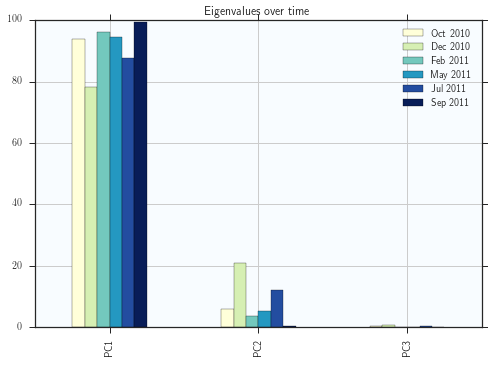

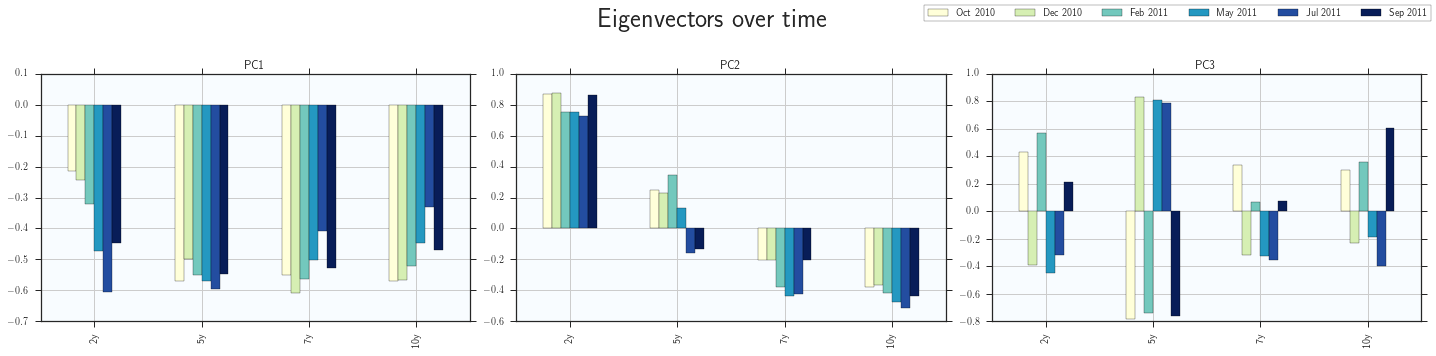

In [127]:
evalues = testSnap[0]
evectors = testSnap[1]

## Eigenvalues
display(evalues)
dateStrings = [pd.to_datetime(str(date)).strftime("%b %Y") for date in evalues.index.values]
ax = evalues.transpose().plot(kind="bar", title="Eigenvalues over time", colormap="YlGnBu", grid=True)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, dateStrings, loc="best")
ax.set_axis_bgcolor("#f8fcff")

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20, 5)


for i in range(len(evectors.keys())):
    ax = evectors["PC"+str(i+1)].transpose().plot(ax=axes[i], kind="bar", legend=False, colormap="YlGnBu", grid=True)
    lines, labels = ax.get_legend_handles_labels()
    ax.set_axis_bgcolor('#f8fcff')
    ax.set_title("PC"+str(i+1))
    #ax.legend(lines, dateStrings, loc="best")

fig.suptitle("Eigenvectors over time", fontsize="26")
fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.figlegend(lines, dateStrings, frameon=True,loc="upper right", ncol=len(dateStrings))




Not too bad.

# Generating weights for curve and fly trades

The next thing to do is create a function that would generated trades that are PC hedged. 

In [179]:
def getWgts(trade, evectors,bpvs=0):
    ### Returns risk to use in trades
    eVec = evectors.copy()
    if "-" in trade:
        tenors = trade.split("-")
        
    else:
        tenors = sorted([int(x.strip()) for x in trade.split("s") if x])
        tenors = [str(i)+"y" for i in tenors]
        ## re-index evectors:
        newIndex = [''.join(i for i in x if i.isdigit())+"y" for x in evectors.index.values]
        eVec.index = newIndex

    if len(tenors)==2:
        short = tenors[0]
        long = tenors[1]
        es = evectors.at[short, "PC1"]
        el = evectors.at[long, "PC1"]
        return [-el/es, 1]
        
    
    if len(tenors)==3:
        belly = tenors[1]
        wings = [w for w in tenors if w not in belly]
        wingFactors = pd.DataFrame(index=wings)
        wingFactors = wingFactors.join(eVec).ix[:,:-1].transpose()
        bellyFactor = pd.DataFrame(index=[belly])
        bellyFactor = bellyFactor.join(eVec).ix[:,:-1].transpose()
        invcoeff = np.linalg.pinv(wingFactors)
        bellyFactor.loc[:] *= -1
        rhs = invcoeff.dot(bellyFactor)
        rhs = [2*x for x in list(np.ravel(rhs))]
        rhs.insert(1, 2)
        
        return rhs
    else:
        print("Oops. Not enough, or too many instruments.")
    return

        

Testing it here:

In [180]:
#curve = "25y5y-30y10y"
#fly = "7y3y-10y2y-12y3y"
#longfly = "12y3y-15y5y-20y5y"
#curve = "7s10s"
fly = "2s5s7s"
#longfly = "4s5s6s"
evectors = (pca3["evecs"])
#print (evectors)

pv01s = firv.pv01d
#print (getWgts(curve, pca3["evecs"]))
print (getWgts(fly, pca3["evecs"]))
#print (getWgts(longfly, pca3["evecs"]))

[-0.64980163969832416, 2, -1.5743538823105794]


We are going to need a function to generate the time series for weighted flies. 

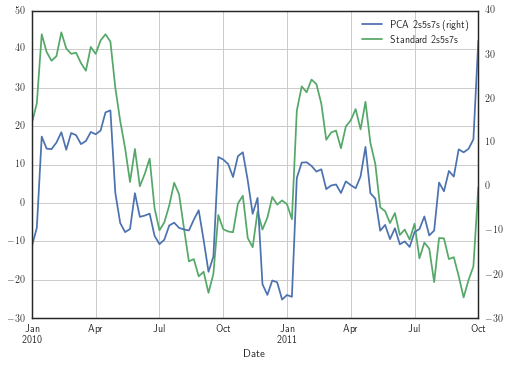

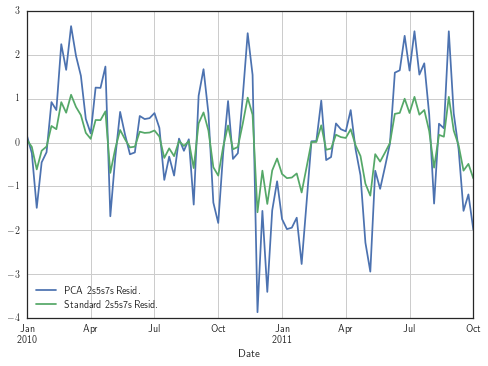

In [181]:
def genTrade(trade, data, pcaResult):
    eVec = pcaResult["evecs"].copy()
    
    
    if "-" in trade:
        tenors = trade.split("-")
        
    else:
        tenors = sorted([int(x.strip()) for x in trade.split("s") if x])
        tenors = [str(i)+"y" for i in tenors]
        ## re-index evectors:
        newIndex = [''.join(i for i in x if i.isdigit())+"y" for x in eVec.index.values]
        eVec.index = newIndex
        
    pcaWgts = getWgts(trade, eVec)
    
    result = data[tenors].copy()
    result["PCA "+trade] = result.dot(pcaWgts)
    
    if len(tenors) == 2:
        result["Standard "+trade] = result[tenors[1]] - result[tenors[0]]
    elif len(tenors)==3:
        legs = data[tenors].copy()
        result["Standard "+trade] = legs.dot(np.array([-1, 2, -1]))
    
    residuals = pcaResult["resid"][tenors].copy()
    residuals["PCA "+trade+" Resid."] = residuals.dot(pcaWgts)
    if len(tenors) == 2:
        residuals["Standard "+trade+" Resid."] = residuals[tenors[1]] - residuals[tenors[0]]
    elif len(tenors)==3:
        rlegs = residuals[tenors].copy()
        residuals["Standard "+trade+" Resid."] = rlegs.dot(np.array([-1, 2, -1]))    
    
    
    return result, residuals

#curveTrade = genTrade(curve, data, evectors)
#curveTrade.ix[:, 2:].plot(secondary_y="PCA "+curve)

flyTrade, flyResiduals = genTrade(fly, data, pca3)
flyTrade.ix[:, 3:].plot(secondary_y="PCA "+fly, grid=True)
flyResiduals.ix[:, 3:].plot(grid=True)

It might be interesting to see what the PCA hedge really means visually by regressing vs. actual movements in the principal components. 

The residuals above point to receiving 2s5s10s. Let's model this trade. 

In [182]:
histFactors = pca3["facTS"]
residuals = pca3["resid"]
diffFactors = histFactors.diff()
display(histFactors.tail())
display(diffFactors.tail())
#curves = curveTrade.ix[:, 2:]
#curvesChg = curves.diff()
flies = flyTrade.ix[:, 3:]
fliesChg = flies.diff()
#display(curves.tail())
#display(curvesChg.tail())
display(flies.tail())
display(fliesChg.tail())

,PC1,PC2,PC3
Date,,,
2011-09-05,-179.730137,-18.633247,-3.982912
2011-09-12,-192.511588,-26.034951,-4.038470
2011-09-19,-179.710731,-23.857772,-4.909121
2011-09-26,-176.846829,-21.022984,-5.622460
2011-10-03,-169.223186,-26.073426,-14.883632


,PC1,PC2,PC3
Date,,,
2011-09-05,-72.759089,-0.823403,-3.215526
2011-09-12,-12.781451,-7.401704,-0.055558
2011-09-19,12.800858,2.177179,-0.870651
2011-09-26,2.863902,2.834788,-0.713339
2011-10-03,7.623643,-5.050442,-9.261172


,PCA 2s5s7s,Standard 2s5s7s
Date,,
2011-09-05,8.458239,-19.054687
2011-09-12,7.778060,-24.654687
2011-09-19,8.561518,-20.154687
2011-09-26,10.729858,-16.554687
2011-10-03,33.215343,4.045313


,PCA 2s5s7s,Standard 2s5s7s
Date,,
2011-09-05,6.216396,-4.9
2011-09-12,-0.680179,-5.6
2011-09-19,0.783458,4.5
2011-09-26,2.168341,3.6
2011-10-03,22.485485,20.6


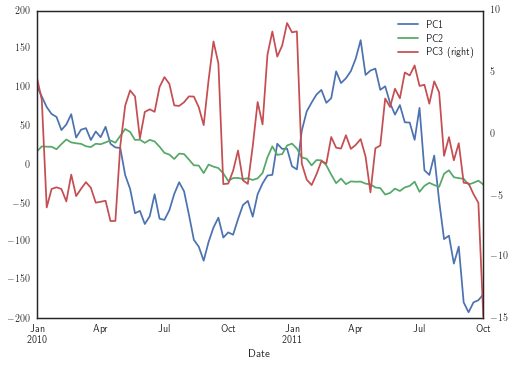

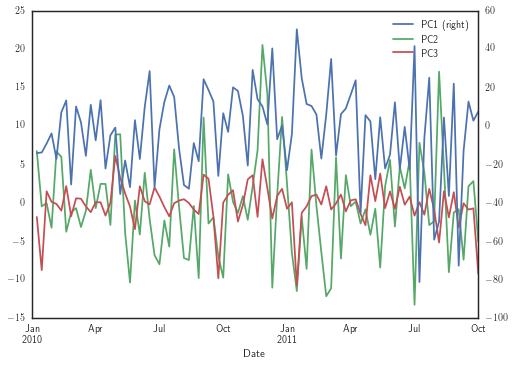

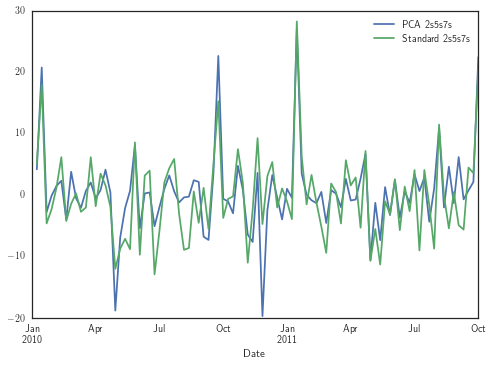

In [183]:
histFactors.plot(secondary_y="PC3")
diffFactors.plot(secondary_y="PC1")
fliesChg.plot()

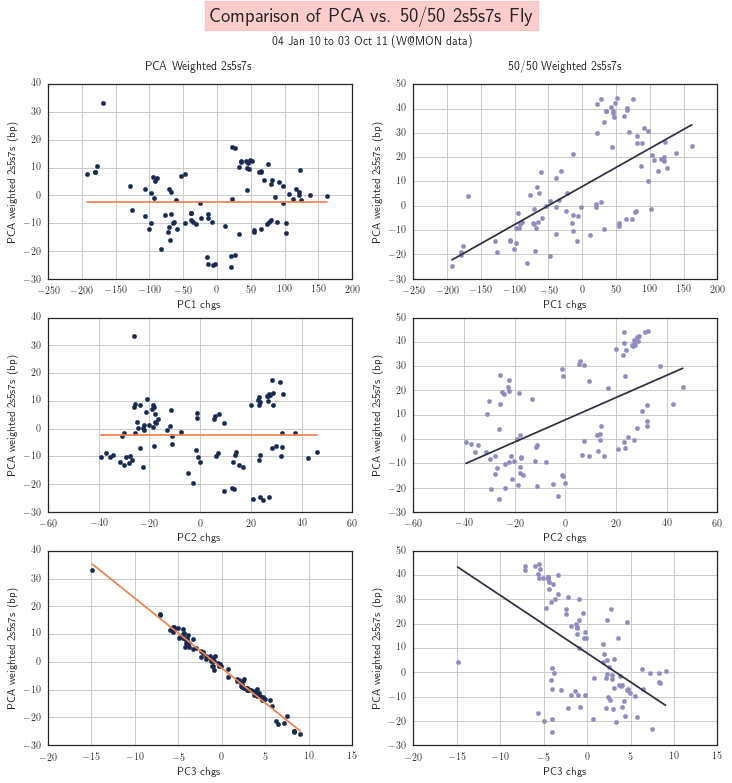

In [199]:
import statsmodels.api as sm
firstDate = data.index[0].strftime("%d %b %y")
lastDate = data.index[-1].strftime("%d %b %y")
pcaFly = flyTrade["PCA "+fly].dropna().values
stdFly = flyTrade["Standard "+fly].dropna().values

across = ["PCA "+fly, "Std "+fly]

down = histFactors.index.values

trades = [pcaFly, stdFly]


def pcSensitivity():
    fig, axes = plt.subplots(3, 2)
    fig.set_size_inches(12,12)
    fig.suptitle("Comparison of PCA vs. 50/50 "+fly+" Fly", fontsize=20,bbox={'facecolor':'red', 'alpha':0.2, 'pad':5})
    fig.text(0.5, 0.94, "%s to %s (%s data)"%(firstDate, lastDate, freq),ha='center', va='center')
    
    fig.subplots_adjust(top=0.89)
    for i in range(len(axes)):
        x = histFactors["PC"+str(i+1)].dropna().values
        y = trades
        plot(axes[i], x, y, i)
    
    axes[0][1].set_title("50/50 Weighted "+fly, y=1.05)
    axes[0][0].set_title("PCA Weighted "+fly, y=1.05)

    plt.show()

def plot(axrow, x, y, i):
    axrow[0].scatter(x, y[0], color='#192A51', marker='o')
    axrow[0].grid()
    fit1 = np.polyfit(x, y[1], 1, full=True)
    axrow[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y[0], 1))(np.unique(x)), color="#EF8354")
    axrow[0].set_ylabel("PCA weighted "+fly+" (bp)")
    axrow[0].set_xlabel("PC"+str(i+1)+" chgs")
    
    axrow[1].scatter(x, y[1], color='#8E8DBE')
    axrow[1].grid()
    fit2 = np.polyfit(x, y[1], 1, full=True)
    axrow[1].plot(np.unique(x), np.poly1d(np.polyfit(x, y[1], 1))(np.unique(x)), color='#2D3142')
    axrow[1].set_ylabel("PCA weighted "+fly+" (bp)")
    axrow[1].set_xlabel("PC"+str(i+1)+" chgs")


pcSensitivity()

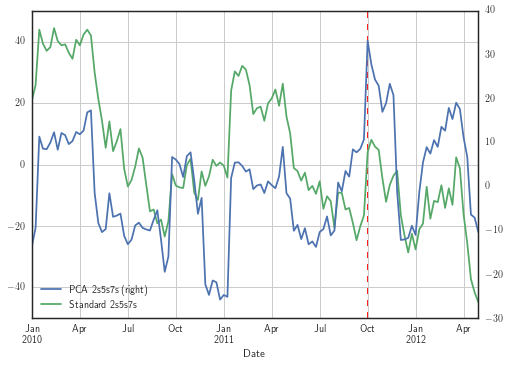

In [185]:
#curvePerf = genTrade(curve, rawData[end:dt.datetime(2016, 12, 30)], evectors)
flyPerf = genTrade(fly, brawData[dt.datetime(2010, 1, 4):dt.datetime(2012, 5, 1)], pca3)[0]

#curvePerf.ix[:, 2:].plot() ## Receive this
ax1 = flyPerf.ix[:, 3:].plot(secondary_y="PCA "+fly) ## pay this
ax1.axvline(dt.datetime(2011,10, 3), color='r', zorder=0, ls="dashed")
ax1.grid()


## Mean Reversion

The fly looks like it mean reverts quite well. Let's try using the ADF test.

In [189]:
import statsmodels.tsa.stattools as ts
print(ts.adfuller(flyResiduals.ix[:,3], 1))

(-4.605974934521007, 0.0001259334954715697, 0, 91, {'5%': -2.8938659630479413, '10%': -2.5840147047458037, '1%': -3.5043428982139702}, 280.83025737173364)


Since the test statistic of -4.6 is smaller than the 1% critical level, the series is likely to be mean reverting. 

In [210]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(1,len(ts)-1)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

print (hurst(pcaFly))

-0.0321791619481
